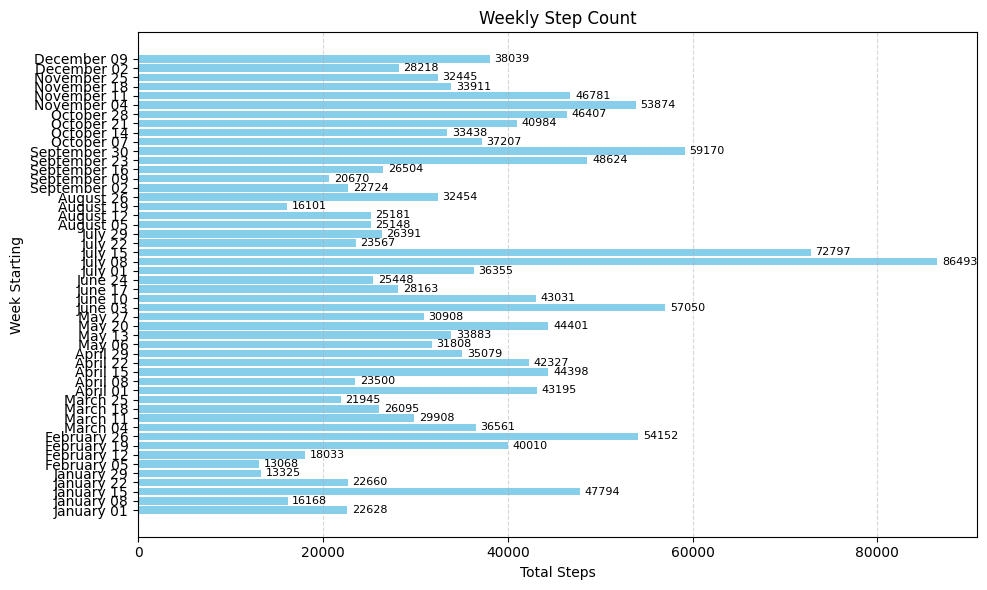

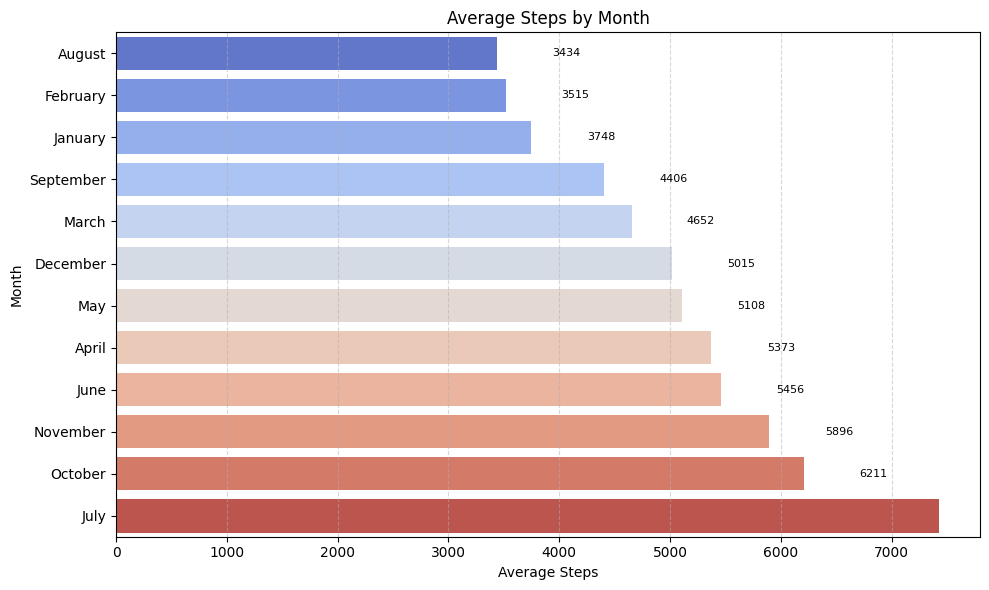

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xml.etree.ElementTree as ET

# ---------- Step 1: Parse the XML File ----------
# Path to the export.xml file
xml_file_path = "export.xml"

# Parse the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Extract records for Steps, Flights Climbed, and Calories Burned
data = []
for record in root.findall("Record"):
    record_type = record.attrib.get("type")
    value = float(record.attrib.get("value", 0))
    date = pd.to_datetime(record.attrib.get("startDate", "").split(" ")[0])

    # Filter only relevant data types
    if record_type in ["HKQuantityTypeIdentifierStepCount", 
                       "HKQuantityTypeIdentifierFlightsClimbed", 
                       "HKQuantityTypeIdentifierActiveEnergyBurned"]:
        data.append({"Date": date, "Type": record_type, "Value": value})

# Convert the data into a DataFrame
df_health = pd.DataFrame(data)

# Rename 'Type' for readability
df_health["Type"] = df_health["Type"].replace({
    "HKQuantityTypeIdentifierStepCount": "Steps",
    "HKQuantityTypeIdentifierFlightsClimbed": "Flights Climbed",
    "HKQuantityTypeIdentifierActiveEnergyBurned": "Calories Burned"
})

# Pivot the DataFrame to have metrics as columns
df_pivot = df_health.pivot_table(index="Date", columns="Type", values="Value", aggfunc="sum").reset_index()
df_pivot.fillna(0, inplace=True)  # Replace NaN with 0

# ---------- Step 2: Weekly Aggregation ----------
# Calculate WeekStart (Monday of each week)
df_pivot["WeekStart"] = df_pivot["Date"] - pd.to_timedelta(df_pivot["Date"].dt.weekday, unit="D")
weekly_summary = df_pivot.groupby("WeekStart")[["Steps", "Flights Climbed", "Calories Burned"]].sum().reset_index()

# ---------- Step 3: Monthly Aggregation ----------
df_pivot["Month"] = df_pivot["Date"].dt.strftime("%B")
monthly_summary = df_pivot.groupby("Month")[["Steps", "Flights Climbed", "Calories Burned"]].mean().sort_values("Steps")

# ---------- Step 4: Weekly Bar Plot ----------
plt.figure(figsize=(10, 6))
plt.barh(y=weekly_summary["WeekStart"].dt.strftime("%B %d"), width=weekly_summary["Steps"], color="skyblue")

# Annotate values on the bars
for index, value in enumerate(weekly_summary["Steps"]):
    plt.annotate(f"{value:.0f}", xy=(value + 500, index), va="center", fontsize=8)

plt.title("Weekly Step Count")
plt.xlabel("Total Steps")
plt.ylabel("Week Starting")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ---------- Step 5: Monthly Bar Plot ----------
plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_summary, x="Steps", y=monthly_summary.index, hue="Month", palette="coolwarm", dodge=False, legend=False)

# Annotate values on the bars
for index, row in monthly_summary.iterrows():
    plt.annotate(f"{row['Steps']:.0f}", xy=(row["Steps"] + 500, index), va="center", fontsize=8)

plt.title("Average Steps by Month")
plt.xlabel("Average Steps")
plt.ylabel("Month")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


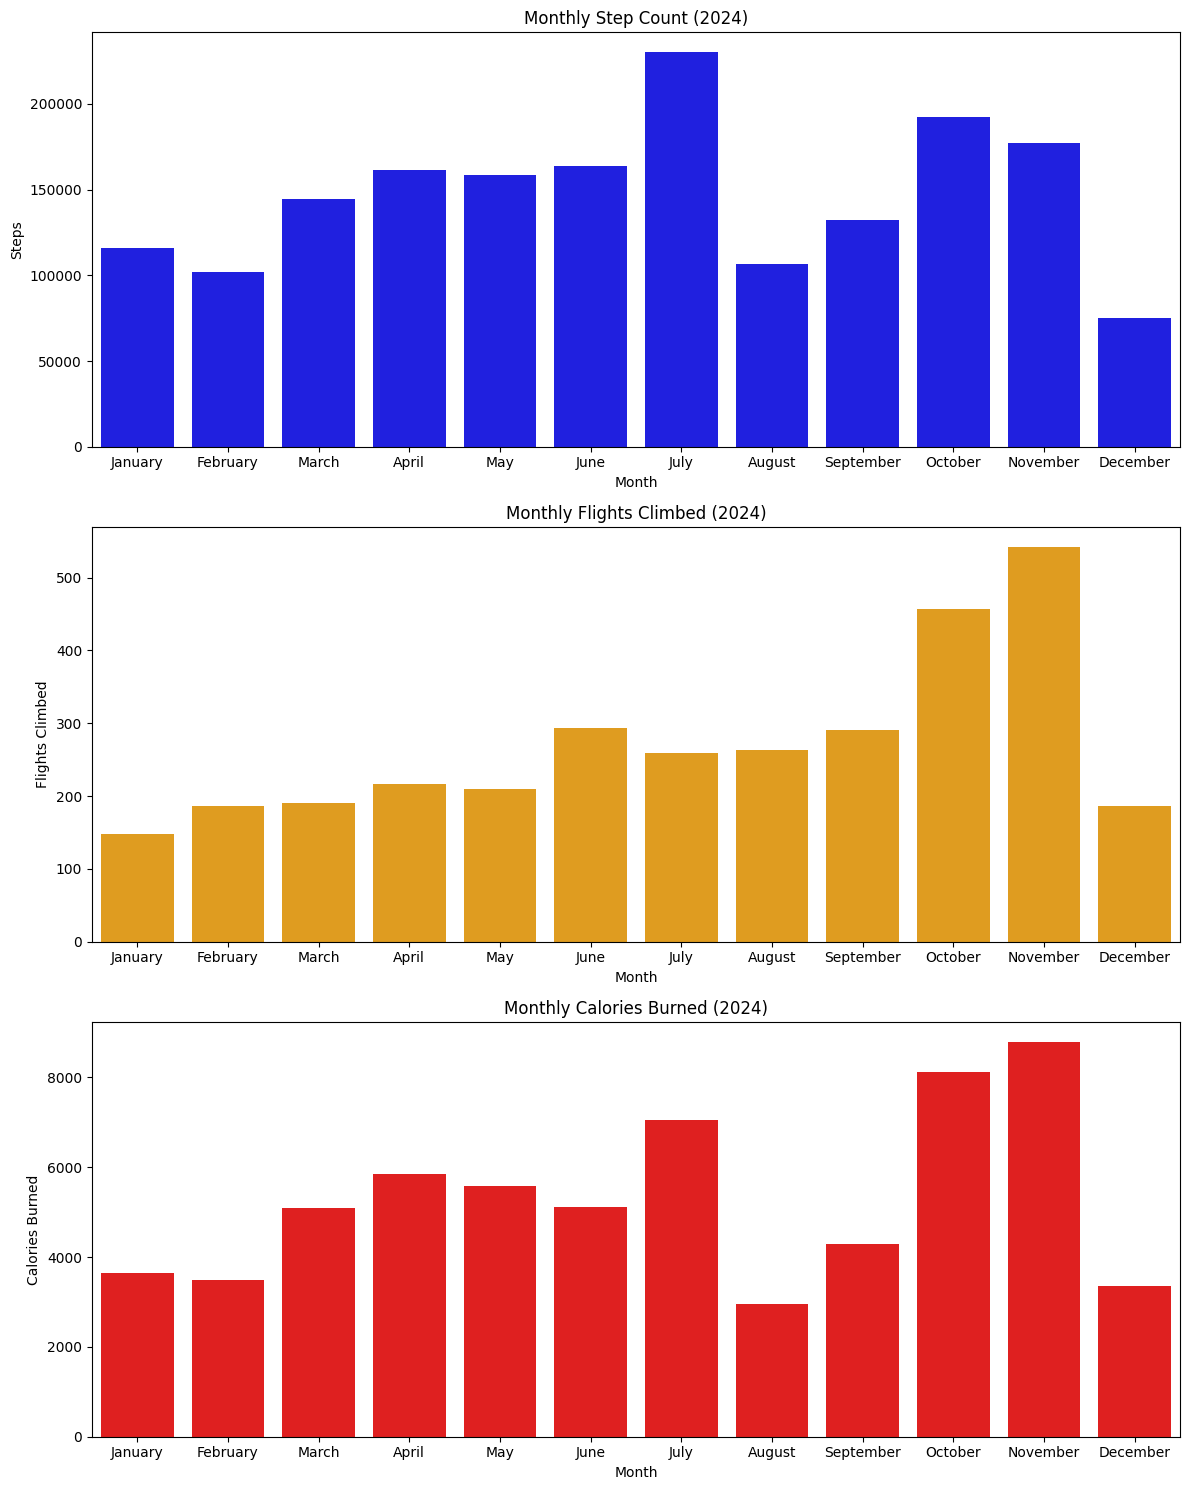

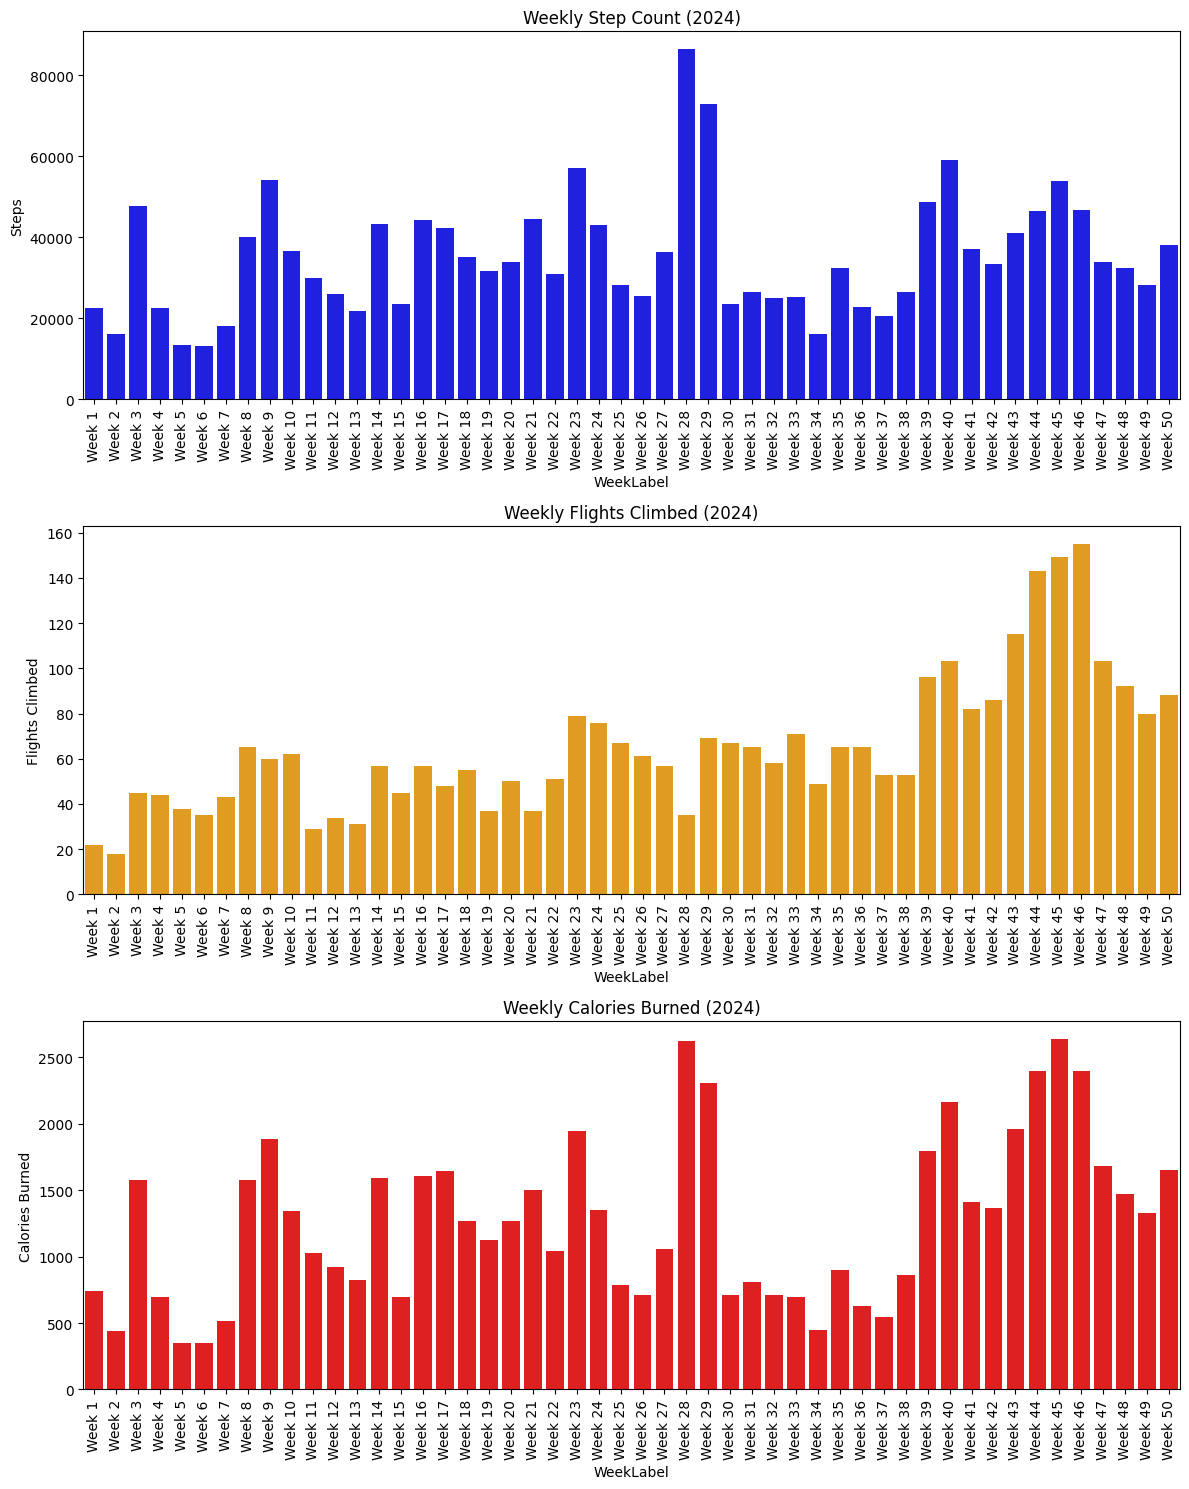

In [2]:
# ---------- Step 1: Filter Data ----------
# Convert "Date" column to datetime
df_pivot["Date"] = pd.to_datetime(df_pivot["Date"])

# Filter data for the specific date range (01.01.2024 to 16.12.2024)
filtered_df = df_pivot[(df_pivot["Date"] >= "2024-01-01") & (df_pivot["Date"] <= "2024-12-16")].copy()

# ---------- Step 2: Monthly Aggregation ----------
# Extract month names and group data
filtered_df["Month"] = filtered_df["Date"].dt.strftime("%B")
monthly_summary = filtered_df.groupby("Month")[["Steps", "Flights Climbed", "Calories Burned"]].sum().reset_index()

# Sort months in calendar order
months_order = ["January", "February", "March", "April", "May", "June",
                "July", "August", "September", "October", "November", "December"]
monthly_summary["Month"] = pd.Categorical(monthly_summary["Month"], categories=months_order, ordered=True)
monthly_summary = monthly_summary.sort_values("Month")

# ---------- Step 3: Weekly Aggregation ----------
# Calculate Week Numbers
filtered_df["Week"] = ((filtered_df["Date"] - filtered_df["Date"].min()).dt.days // 7) + 1
weekly_summary = filtered_df.groupby("Week")[["Steps", "Flights Climbed", "Calories Burned"]].sum().reset_index()

# Rename weeks as "Week 1", "Week 2", etc.
weekly_summary["WeekLabel"] = "Week " + weekly_summary["Week"].astype(str)

# ---------- Step 4: Monthly Plots ----------
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Monthly Steps
sns.barplot(data=monthly_summary, x="Month", y="Steps", ax=axes[0], color="blue")
axes[0].set_title("Monthly Step Count (2024)")
axes[0].set_ylabel("Steps")

# Monthly Flights Climbed
sns.barplot(data=monthly_summary, x="Month", y="Flights Climbed", ax=axes[1], color="orange")
axes[1].set_title("Monthly Flights Climbed (2024)")
axes[1].set_ylabel("Flights Climbed")

# Monthly Calories Burned
sns.barplot(data=monthly_summary, x="Month", y="Calories Burned", ax=axes[2], color="red")
axes[2].set_title("Monthly Calories Burned (2024)")
axes[2].set_ylabel("Calories Burned")

plt.tight_layout()
plt.show()

# ---------- Step 5: Weekly Plots ----------
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Weekly Steps
sns.barplot(data=weekly_summary, x="WeekLabel", y="Steps", ax=axes[0], color="blue")
axes[0].set_title("Weekly Step Count (2024)")
axes[0].set_ylabel("Steps")
axes[0].tick_params(axis='x', rotation=90)

# Weekly Flights Climbed
sns.barplot(data=weekly_summary, x="WeekLabel", y="Flights Climbed", ax=axes[1], color="orange")
axes[1].set_title("Weekly Flights Climbed (2024)")
axes[1].set_ylabel("Flights Climbed")
axes[1].tick_params(axis='x', rotation=90)

# Weekly Calories Burned
sns.barplot(data=weekly_summary, x="WeekLabel", y="Calories Burned", ax=axes[2], color="red")
axes[2].set_title("Weekly Calories Burned (2024)")
axes[2].set_ylabel("Calories Burned")
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


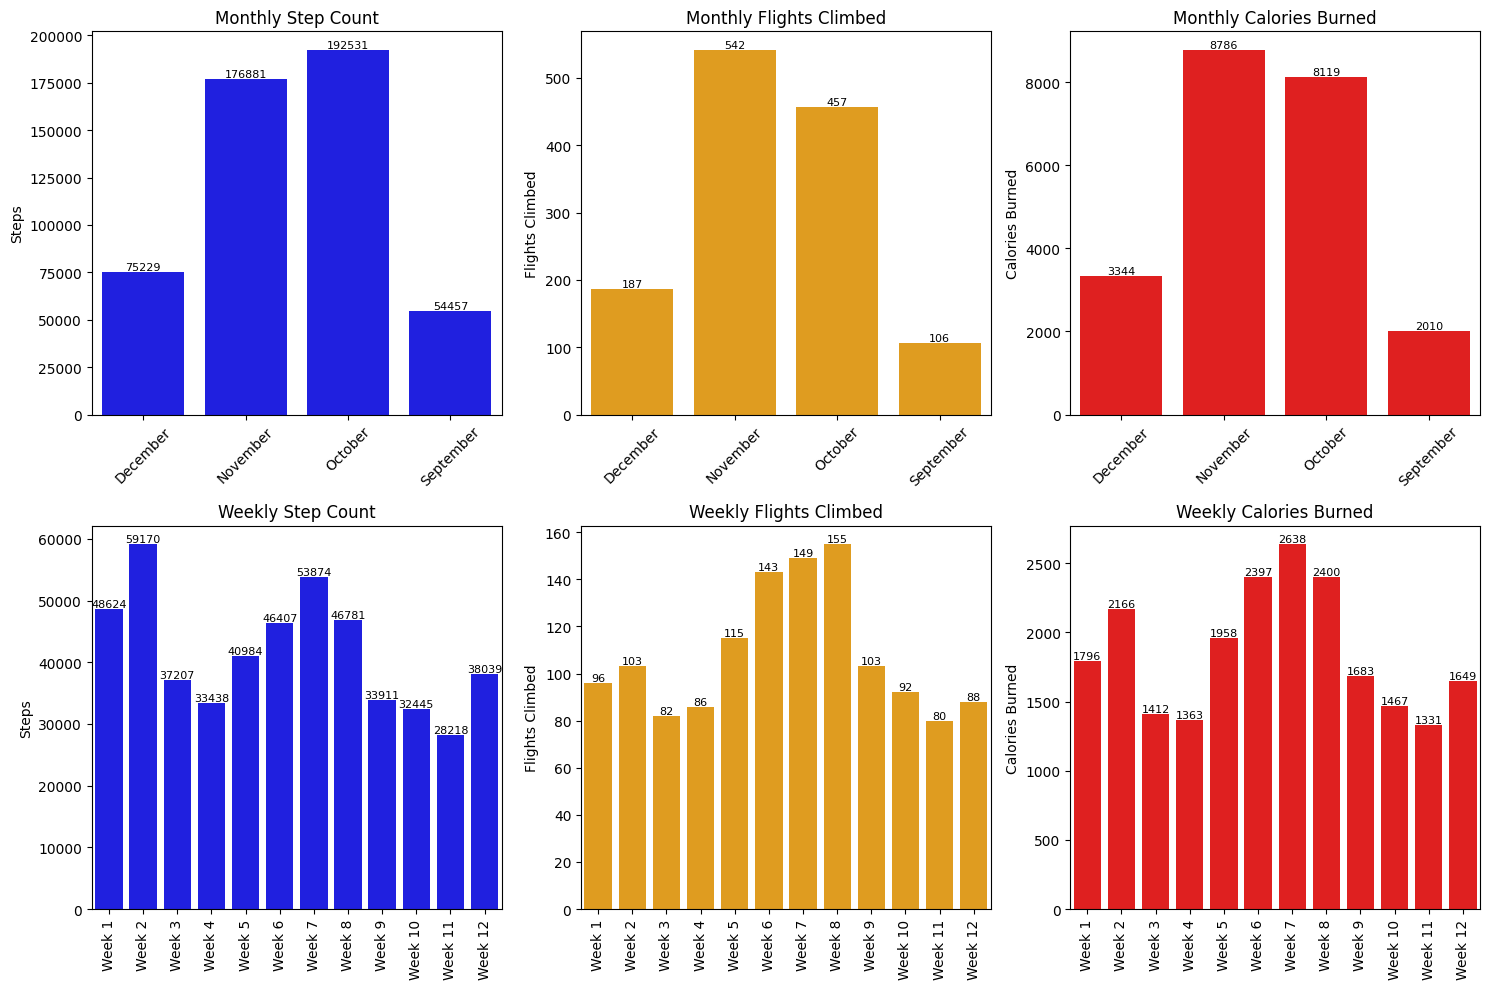

In [15]:
# ---------- Function to Aggregate Data ----------
def aggregate_data(df, group_by, agg_cols, agg_func="sum", rename_weeks=False):
    summary = df.groupby(group_by)[agg_cols].agg(agg_func).reset_index()
    if rename_weeks:  # Add 'Week X' labels for weekly data
        summary["WeekLabel"] = "Week " + summary[group_by].astype(str)
    return summary

# ---------- Function to Plot Data ----------
def plot_data(summary_df, x_col, y_col, title, ax, color="blue", rotation=0):
    sns.barplot(data=summary_df, x=x_col, y=y_col, ax=ax, color=color)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=rotation)
    for index, value in enumerate(summary_df[y_col]):
        ax.annotate(f"{value:.0f}", xy=(index, value), ha="center", va="bottom", fontsize=8)

# ---------- Step 1: Filter Data ----------
filtered_df = df_pivot[(df_pivot["Date"] >= "2024-09-23") & (df_pivot["Date"] <= "2024-12-15")].copy()

# Add 'Week' and 'Month' for Aggregation
filtered_df["Week"] = ((filtered_df["Date"] - filtered_df["Date"].min()).dt.days // 7) + 1
filtered_df["Month"] = filtered_df["Date"].dt.strftime("%B")

# ---------- Step 2: Aggregate Data ----------
weekly_summary = aggregate_data(filtered_df, "Week", ["Steps", "Flights Climbed", "Calories Burned"], rename_weeks=True)
monthly_summary = aggregate_data(filtered_df, "Month", ["Steps", "Flights Climbed", "Calories Burned"])

# ---------- Step 3: Plot Data ----------
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Monthly Plots
plot_data(monthly_summary, "Month", "Steps", "Monthly Step Count", axes[0, 0], "blue", rotation=45)
plot_data(monthly_summary, "Month", "Flights Climbed", "Monthly Flights Climbed", axes[0, 1], "orange", rotation=45)
plot_data(monthly_summary, "Month", "Calories Burned", "Monthly Calories Burned", axes[0, 2], "red", rotation=45)

# Weekly Plots
plot_data(weekly_summary, "WeekLabel", "Steps", "Weekly Step Count", axes[1, 0], "blue", rotation=90)
plot_data(weekly_summary, "WeekLabel", "Flights Climbed", "Weekly Flights Climbed", axes[1, 1], "orange", rotation=90)
plot_data(weekly_summary, "WeekLabel", "Calories Burned", "Weekly Calories Burned", axes[1, 2], "red", rotation=90)

plt.tight_layout()
plt.show()


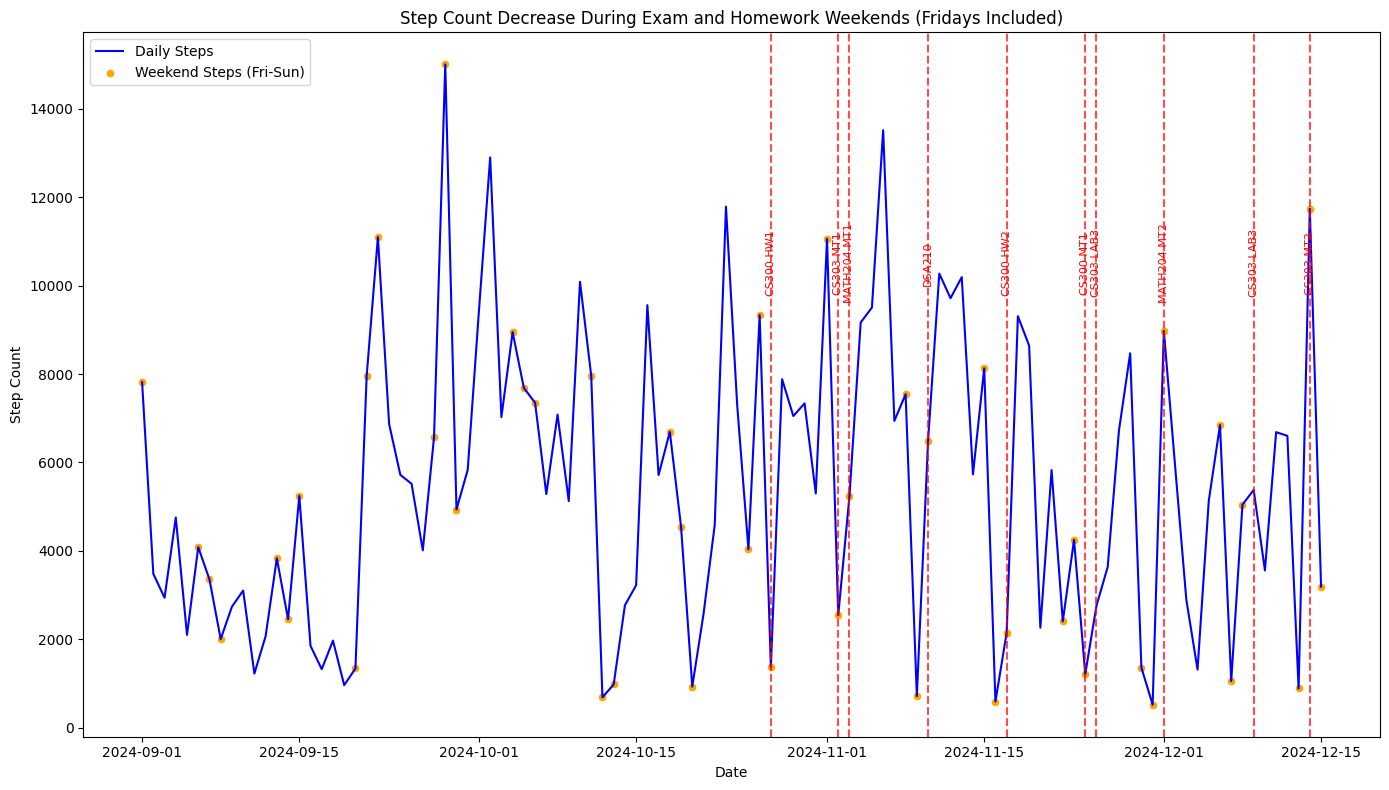

In [14]:
# Assignments and Exams Data
events = [
    {"name": "CS300 HW1", "date": "2024-10-27"},
    {"name": "CS303 MT1", "date": "2024-11-02"},
    {"name": "MATH204 MT1", "date": "2024-11-03"},
    {"name": "DSA210", "date": "2024-11-10"},
    {"name": "CS300 HW2", "date": "2024-11-17"},
    {"name": "CS300 MT1", "date": "2024-11-24"},
    {"name": "CS303 LAB3", "date": "2024-11-25"},
    {"name": "MATH204 MT2", "date": "2024-12-01"},
    {"name": "CS303 LAB3", "date": "2024-12-09"},
    {"name": "CS303 MT2", "date": "2024-12-14"},
]

# Convert merged_df date column to datetime
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Filter data for September to December 2024
filtered_df = merged_df[(merged_df["Date"] >= "2024-09-01") & (merged_df["Date"] <= "2024-12-31")].copy()

# Add a column for the day of the week
filtered_df["DayOfWeek"] = filtered_df["Date"].dt.day_name()

# Flag weekends (Friday to Sunday)
filtered_df["WeekendFlag"] = filtered_df["DayOfWeek"].isin(["Friday", "Saturday", "Sunday"])

# Plot step count for weekends and annotate events
plt.figure(figsize=(14, 8))

# Highlight step count on weekends
sns.lineplot(data=filtered_df, x="Date", y="Steps", label="Daily Steps", color="blue")
sns.scatterplot(
    data=filtered_df[filtered_df["WeekendFlag"]],
    x="Date",
    y="Steps",
    color="orange",
    label="Weekend Steps (Fri-Sun)"
)

# Annotate academic events
for event in events:
    event_date = pd.to_datetime(event["date"])
    # Annotate only if the event date is within the filtered range
    if event_date in filtered_df["Date"].values:
        plt.axvline(event_date, color="red", linestyle="--", alpha=0.7)
        plt.text(event_date, filtered_df["Steps"].max() * 0.7, event["name"],
                 rotation=90, color="red", fontsize=8, ha="center", va="center")

# Add labels and title
plt.title("Step Count Decrease During Exam and Homework Weekends (Fridays Included)")
plt.xlabel("Date")
plt.ylabel("Step Count")
plt.legend()

# Improve layout
plt.tight_layout()
plt.show()


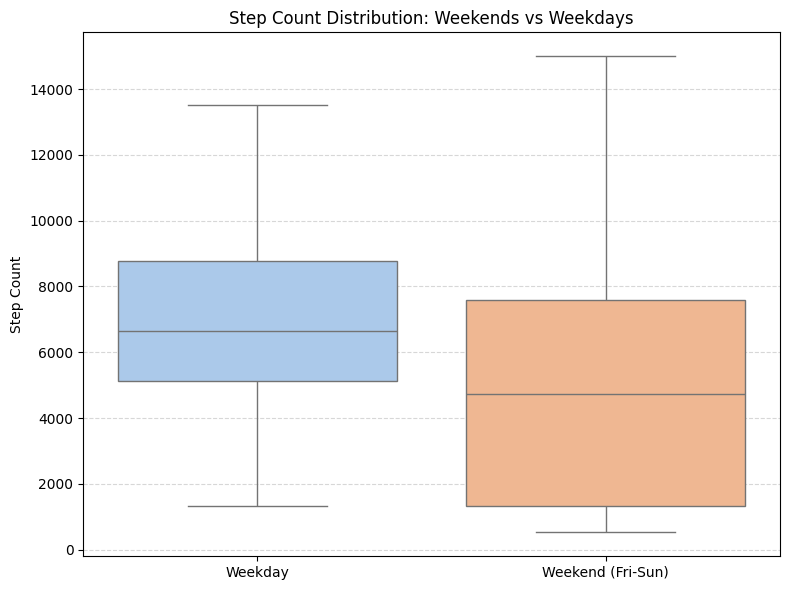

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure filtered_df is a standalone DataFrame
filtered_df = filtered_df.copy()

# ---------- Step 1: Extract Day of Week ----------
# Convert 'Date' column to datetime if not already
filtered_df["Date"] = pd.to_datetime(filtered_df["Date"], errors="coerce")

# Extract Day of the Week
filtered_df["DayOfWeek"] = filtered_df["Date"].dt.day_name()

# Label Days as 'Weekend' or 'Weekday'
filtered_df["DayType"] = filtered_df["DayOfWeek"].apply(
    lambda x: "Weekend (Fri-Sun)" if x in ["Friday", "Saturday", "Sunday"] else "Weekday"
)

# ---------- Step 2: Boxplot ----------
plt.figure(figsize=(8, 6))

# Plot the boxplot for Step Count distribution
sns.boxplot(data=filtered_df, x="DayType", y="Steps", hue="DayType", palette="pastel", legend=False)

# Add title and labels
plt.title("Step Count Distribution: Weekends vs Weekdays")
plt.xlabel("")
plt.ylabel("Step Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()


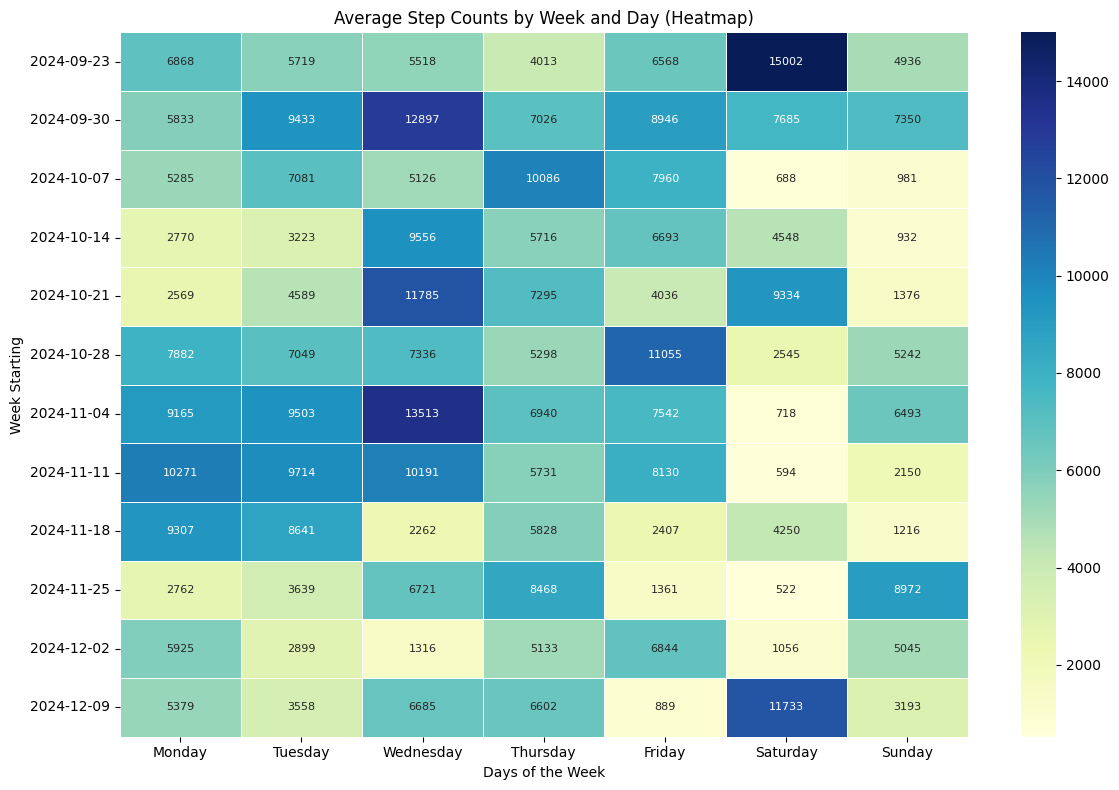

In [18]:
# Ensure filtered_df is a standalone DataFrame
filtered_df = filtered_df.copy()

# ---------- Step 1: Ensure Date is Datetime ----------
filtered_df["Date"] = pd.to_datetime(filtered_df["Date"], errors="coerce")

# Extract Week Start (remove hours) and Day of the Week
filtered_df["Week"] = filtered_df["Date"].dt.to_period("W").apply(lambda r: r.start_time.date())  # Only date, no time
filtered_df["DayOfWeek"] = filtered_df["Date"].dt.day_name()

# ---------- Step 2: Prepare Data for Heatmap ----------
pivot_table = filtered_df.pivot_table(
    index="Week", 
    columns="DayOfWeek", 
    values="Steps", 
    aggfunc="mean"
)

# Reorder columns to ensure Monday-Sunday order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot_table = pivot_table.reindex(columns=day_order)

# ---------- Step 3: Plot Heatmap ----------
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table, 
    cmap="YlGnBu", 
    annot=True, 
    fmt=".0f", 
    linewidths=0.5, 
    annot_kws={"size": 8}  # Adjust annotation font size
)

# Add title and labels
plt.title("Average Step Counts by Week and Day (Heatmap)")
plt.xlabel("Days of the Week")
plt.ylabel("Week Starting")

# Improve layout
plt.tight_layout()
plt.show()
